In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_scatter import scatter_add
import matplotlib.pyplot as plt

In [ ]:
# Function to generate a simple beam-like graph
def generate_beam_graph(num_nodes=20, length=10.0):
    x_positions = torch.linspace(0, length, num_nodes)
    y_positions = torch.zeros_like(x_positions)
    pos = torch.stack([x_positions, y_positions], dim=1)  # [N, 2]

    # Create edges (connect consecutive nodes)
    edge_index = torch.tensor([[i, i+1] for i in range(num_nodes-1)], dtype=torch.long).T
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Make edges bidirectional

    # Compute edge lengths
    edge_attr = torch.norm(pos[edge_index[1]] - pos[edge_index[0]], dim=1)

    return Data(pos=pos, edge_index=edge_index, edge_attr=edge_attr)

# Function to compute displacement and its analytical derivative
def analytical_displacement(x, L, q, E, I):
    return (q / (24 * E * I)) * x**2 * (x - 4 * L)

def analytical_gradient(x, L, q, E, I):
    return (q / (24 * E * I)) * (3 * x**2 - 8 * L * x)

def comp_grad_fast(data, f, reg=1e-6):
    pos = data.pos  # Node positions
    N, d = pos.shape

    i, j = data.edge_index  # Edge indices

    dx = pos[j] - pos[i]  # Edge direction vectors [E, d]
    du = f[j] - f[i] # Function difference [E, 1]

    weight = (1.0 / (data.edge_attr.view(-1, 1) + 1e-6))  # [E]

    dx_weighted = dx * weight  # [E, d]
    du_weighted = du * weight  # [E, 1]

    outer_dx = dx_weighted.unsqueeze(-1) * dx.unsqueeze(1)  # [E, d, d]
    M = scatter_add(outer_dx, i, dim=0, dim_size=N)  # [N, d, d]

    # Apply weights to `b`
    b = scatter_add(dx_weighted * du, i, dim=0, dim_size=N)

    reg_eye = reg * torch.eye(d, device=M.device).unsqueeze(0)  # [1, d, d]
    M_reg = M + reg_eye

    # Invert M for each node in a batch
    M_inv = torch.linalg.inv(M_reg)  # [N, d, d]

    # Compute gradient
    gradients = torch.einsum("nij,nj->ni", M_inv, b)  # [N, d]

    return gradients

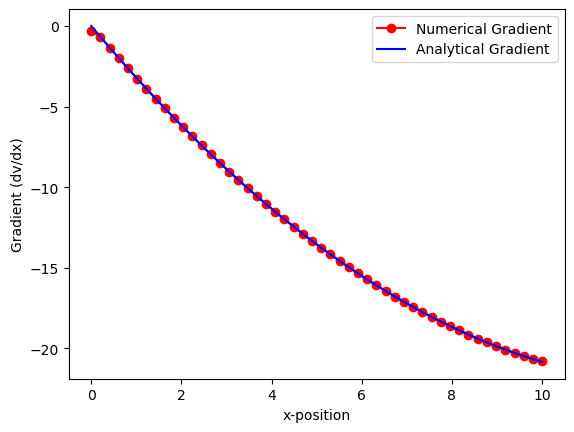

In [17]:


# Set parameters
L = 10.0  # Beam length
q = 1.0   # Uniform load
E = 1.0   # Young's modulus (arbitrary units)
I = 1.0   # Second moment of area (arbitrary units)

# Generate graph
data = generate_beam_graph(num_nodes=50, length=L)

# Compute displacement using analytical function
f = analytical_displacement(data.pos[:, 0], L, q, E, I).view(-1, 1)  # Displacement at each node
# Compute numerical gradients
numerical_gradients = comp_grad_fast(data, f)

# Compute analytical gradients for comparison
analytical_gradients = analytical_gradient(data.pos[:, 0], L, q, E, I)


x_vals = data.pos[:, 0].detach().numpy()
num_grad = numerical_gradients[:, 0].detach().numpy()
ana_grad = analytical_gradients.detach().numpy()

plt.plot(x_vals, num_grad, 'ro-', label="Numerical Gradient")
plt.plot(x_vals, ana_grad, 'b-', label="Analytical Gradient")
plt.xlabel("x-position")
plt.ylabel("Gradient (dv/dx)")
plt.legend()
plt.show()
